<a href="https://colab.research.google.com/github/fatemeh-kn/image-processing/blob/main/Comparing_Prediction_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tutorial on how to compare machine learning methods with the python library scikit-learn. We'll be using the Indian Liver Disease dataset (found here https://www.kaggle.com/uciml/indian-liver-patient-records).

From the dataset page:

"This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records."

I've used Jason Brownlee's article (https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/) from 2016 as the basis for this article...I wanted to expand a bit on what he did as well as use a different dataset.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




In [2]:
#read in the data
data = pd.read_excel('./sample_data/Image_Features.xlsx', sheet_name="Data")

In [3]:
data.head()

,SN,R 0.05,R 0.25,R 0.50,R 0.75,R 0.95,G 0.05,G 0.25,G 0.50,G 0.75,...,B 0.75,B 0.95,name,status,R average,red fraction (R 0.05),red fraction (R 0.25),red fraction (R 0.5),erythema index,assigned
0,4,124,150,161,169,178,89,111,121,129.0,...,109,121.0,C:\Users\fa_ke\crpd_402-4-26-5 (5).tiff,1,120.807030,0.427350,0.421466,0.407323,0.144032,0
1,14,114,127,136,146,157,85,94,101,109.0,...,93,102.0,C:\Users\fa_ke\crpd_402-4-28-16 (1).tiff,1,116.752300,0.427609,0.422360,0.415344,0.127486,0
2,28,153,163,170,176,184,116,125,131,137.0,...,128,137.0,C:\Users\fa_ke\crpd_402-5-16-50 (6).tiff,1,130.380667,0.404467,0.402844,0.394850,0.120233,0
3,35,145,168,178,186,196,111,131,140,148.0,...,130,140.0,C:\Users\fa_ke\crpd_402-5-18-57 (5).tiff,1,120.754895,0.409756,0.405467,0.395161,0.116045,0
4,39,161,172,180,187,198,124,134,141,150.0,...,136,146.0,C:\Users\fa_ke\crpd_402-5-21-62 (7).tiff,1,98.315824,0.403756,0.400891,0.392079,0.113404,1


We'll use all columns except Gender for this tutorial. We could use gender by converting the gender to a numeric value (e.g., 0 for Male, 1 for Female) but for the purproses of this post, we'll just skip this column.

In [4]:
data_to_use = data
status = data_to_use['status']
img_name = data_to_use['name']

data_to_use.drop(['SN', 'name', 'status', 'R average'], axis=1, inplace=True)

data_to_use.dropna(inplace=True)
data_to_use.head()

,R 0.05,R 0.25,R 0.50,R 0.75,R 0.95,G 0.05,G 0.25,G 0.50,G 0.75,G 0.95,B 0.05,B 0.25,B 0.50,B 0.75,B 0.95,red fraction (R 0.05),red fraction (R 0.25),red fraction (R 0.5),erythema index,assigned
0,124,150,161,169,178,89,111,121,129.0,138.0,66,90,100,109,121.0,0.427350,0.421466,0.407323,0.144032,0
1,114,127,136,146,157,85,94,101,109.0,119.0,66,76,85,93,102.0,0.427609,0.422360,0.415344,0.127486,0
2,153,163,170,176,184,116,125,131,137.0,145.0,105,115,121,128,137.0,0.404467,0.402844,0.394850,0.120233,0
3,145,168,178,186,196,111,131,140,148.0,160.0,92,111,121,130,140.0,0.409756,0.405467,0.395161,0.116045,0
4,161,172,180,187,198,124,134,141,150.0,161.0,109,120,128,136,146.0,0.403756,0.400891,0.392079,0.113404,1


The 'Dataset' column is the value we are trying to predict...whether the user has liver disease or not so we'll that as our "Y" and the other columns for our "X" array.

In [5]:
values = data_to_use.values
nvar = len(data_to_use.columns)
Y = values[:,-1]
Y = Y.astype('int')
X = values[:,0:nvar-1]


print(X.shape)
print(Y.shape)

(173, 19)
(173,)


Before we run our machine learning models, we need to set a random number to use to seed them. This can be any random number that you'd like it to be. Some people like to use a random number generator but for the purposes of this, I'll just set it to 12 (it could just as easily be 1 or 3 or 1023 or any other number).


In [6]:
random_seed = 12

Now we need to set up our models that we'll be testing out. We'll set up a list of the models and give them each a name. Additionally, I'm going to set up the blank arrays/lists for the outcomes and the names of the models to use for comparison.

In [11]:
outcome = []
model_names = []
models = [('LogReg', LogisticRegression()),
          ('SVM', SVC()),
          ('DecTree', DecisionTreeClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LinDisc', LinearDiscriminantAnalysis()),
          ('GaussianNB', GaussianNB())]

We are going to use a k-fold validation to evaluate each algorithm and will run through each model with a for loop, running the analysis and then storing the outcomes into the lists we created above. We'll use a 10-fold cross validation.


In [12]:
for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits=50, random_state=random_seed, shuffle=True)
    results = model_selection.cross_val_score(model, X, Y, cv=k_fold_validation, scoring='accuracy')
    outcome.append(results)
    print(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.75       0.75       1.         0.75       0.75       1.
 0.5        0.75       1.         0.75       0.75       1.
 1.         0.75       1.         1.         0.75       1.
 1.         0.75       0.75       1.         1.         0.66666667
 1.         0.66666667 1.         1.         1.         0.66666667
 0.66666667 1.         1.         1.         1.         0.33333333
 0.66666667 1.         0.66666667 0.66666667 1.         1.
 0.66666667 1.         1.         0.66666667 1.         1.
 1.         1.        ]
LogReg| Mean=0.861667 STD=0.168828
[0.75       0.75       1.         0.75       0.75       1.
 0.5        0.75       1.         0.75       0.75       1.
 1.         0.75       1.         1.         0.75       1.
 1.         0.75       0.75       1.         1.         0.66666667
 1.         0.66666667 1.         1.         1.         0.66666667
 0.66666667 1.         1.         1.         1.         0.33333333
 0.66666667 1.         0.66666667 0.66666667 1.         1.
 1.     

From the above,

|Method| Mean|STD|
|-|-|-|
LogReg|0.856209 |0.050458
SVM| 0.867647 |0.042590
DecTree| 0.780065 |0.063839
KNN| 0.862092|0.043078
LinDisc| 0.827124 |0.049914
GaussianNB| 0.595425 |0.077731








it looks like the Logistic Regression, Support Vector Machine and Linear Discrimation Analysis methods are providing the best results.  If we take a look at a box plot to see what the accuracy is for each cross validation fold, we can see just how good each does relative to each other and their means.

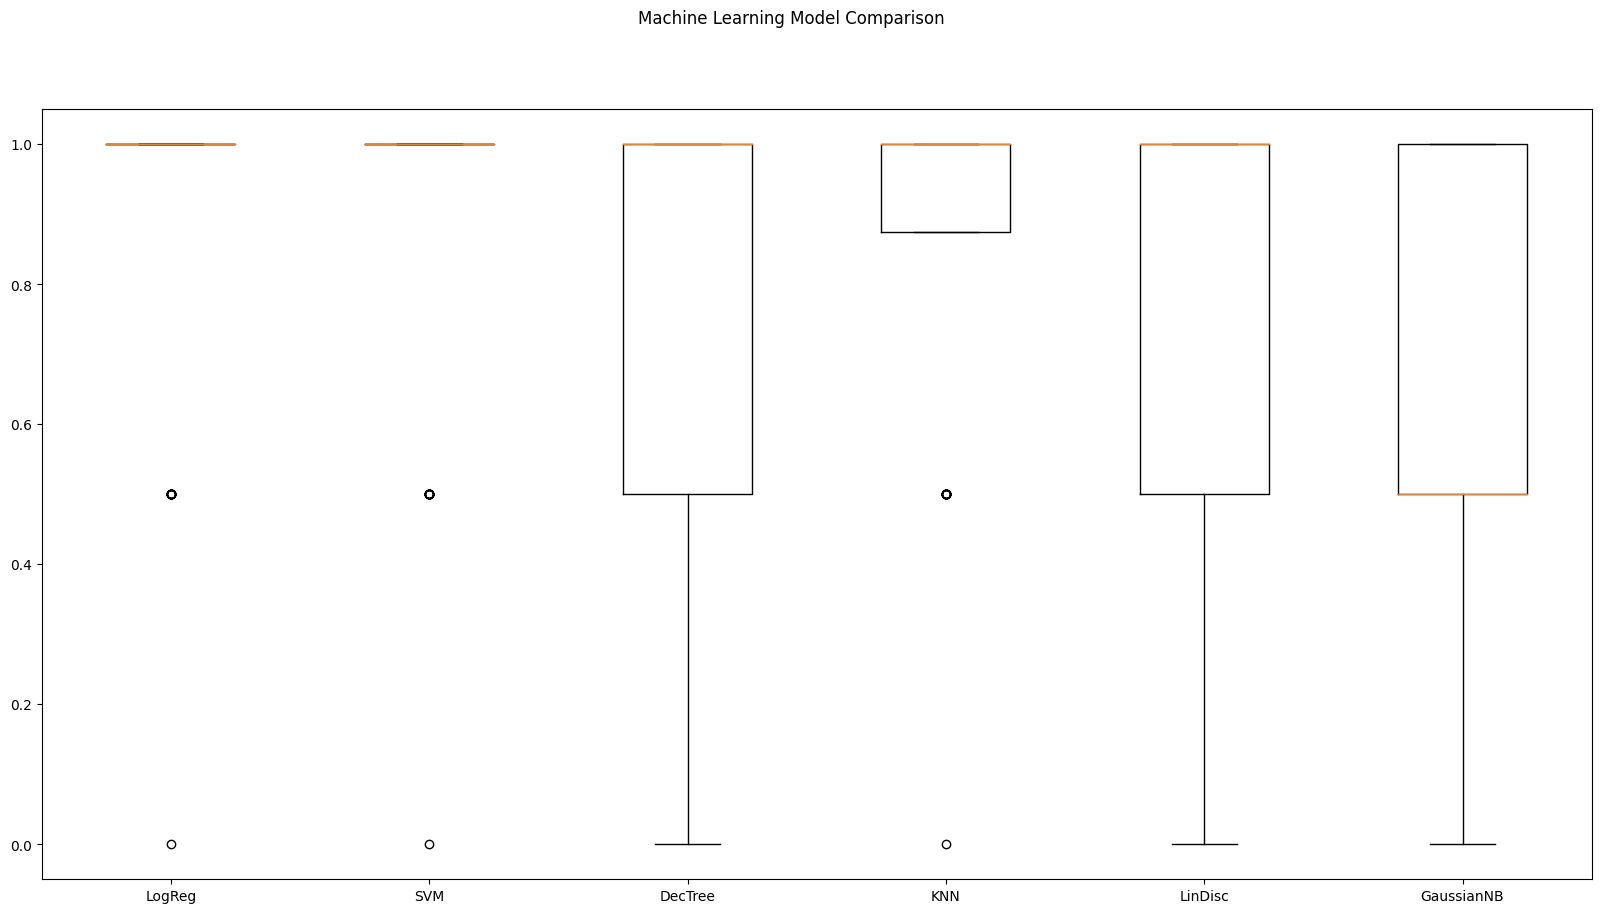

In [9]:
fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Define the algorithms
algorithms = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    GaussianNB()
]

# Train the algorithms
for algorithm in algorithms:
    algorithm.fit(X_train, y_train)

# Make predictions on the test set
predictions_test = []
predictions_all = []



for algorithm in algorithms:
    predictions_test.append(algorithm.predict(X_test))
    predictions_all.append(algorithm.predict(X))

# Compare the accuracy of the algorithms
for i, algorithm in enumerate(algorithms):
    accuracy_test= accuracy_score(y_test, predictions_test[i])
    accuracy = accuracy_score(Y, predictions_all[i])
    print(f"{algorithm.__class__.__name__} Accuracyof test data: {accuracy_test:.4f}")
    print(f"{algorithm.__class__.__name__} Accuracy of all data: {accuracy:.4f}")

LogisticRegression Accuracyof test data: 0.8636
LogisticRegression Accuracy of all data: 0.8613
SVC Accuracyof test data: 0.8636
SVC Accuracy of all data: 0.8671
DecisionTreeClassifier Accuracyof test data: 0.7273
DecisionTreeClassifier Accuracy of all data: 0.9306
LinearDiscriminantAnalysis Accuracyof test data: 0.8182
LinearDiscriminantAnalysis Accuracy of all data: 0.8497
GaussianNB Accuracyof test data: 0.6364
GaussianNB Accuracy of all data: 0.6474


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
